In [1]:
import os
import random
import numpy as np
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.cuda.amp import GradScaler, autocast

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(torch.version.cuda)

print("GPU Available: ", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")



11.7
GPU Available:  True
GPU is available.


In [3]:
torch.cuda.empty_cache()


##### Construct Rain100L Dataset - Load both Rainy and Norainy images

In [84]:
# # Set a random seed
# random.seed(42)

# # Shuffle the norain_files and rain_files before splitting
# random.shuffle(norain_files)
# random.shuffle(rain_files)

# data_path = "Rain100L"
# norain_files = sorted(os.listdir(data_path))
# rain_files = sorted(os.listdir(os.path.join(data_path, "rainy")))

# # Split the dataset
# split = (0.7, 0.2, 0.1)
# total = len(norain_files)
# train_idx = int(total * split[0])
# val_idx = int(total * (split[0] + split[1]))

# train_files = norain_files[:train_idx]
# val_files = norain_files[train_idx:val_idx]
# test_files = norain_files[val_idx:]

# # 2. Create the dataset loader for training, validation, and test sets

# class RainDataset(Dataset):
#     def __init__(self, data_path, norain_files, rain_files, transform=None):
#         self.data_path = data_path
#         self.norain_files = norain_files
#         self.rain_files = rain_files
#         self.transform = transform

#     def __len__(self):
#         return len(self.norain_files)

#     def __getitem__(self, idx):
#         norain_img = Image.open(os.path.join(self.data_path, self.norain_files[idx]))
#         rain_img = Image.open(os.path.join(self.data_path, "rainy", self.rain_files[idx]))

#         if self.transform:
#             norain_img = self.transform(norain_img)
#             rain_img = self.transform(rain_img)

#         return rain_img, norain_img

# transform = transforms.Compose([transforms.ToTensor()])

# train_dataset = RainDataset(data_path, train_files, rain_files[:train_idx], transform)
# val_dataset = RainDataset(data_path, val_files, rain_files[train_idx:val_idx], transform)
# test_dataset = RainDataset(data_path, test_files, rain_files[val_idx:], transform)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [4]:
class Rain100L_Dataset(Dataset):
    def __init__(self, rainy_path, norainy_path, data, transform=None):
        self.rainy_path = rainy_path
        self.norainy_path = norainy_path
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rainy_img_name, norainy_img_name = self.data[idx]
        rainy_image = Image.open(os.path.join(self.rainy_path, rainy_img_name))
        norainy_image = Image.open(os.path.join(self.norainy_path, norainy_img_name))

        if self.transform:
            rainy_image = self.transform(rainy_image)
            norainy_image = self.transform(norainy_image)

        return rainy_image, norainy_image


##### First implementation idea for splitting

In [5]:
def split_data(rainy_path, norainy_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Set a random seed
    random.seed(42)

    rainy_files = sorted(os.listdir(rainy_path))
    norainy_files = sorted(os.listdir(norainy_path))
    
    data_size = len(rainy_files)
    indices = list(range(data_size))
    random.shuffle(indices)

    train_indices = indices[:int(data_size * train_ratio)]
    val_indices = indices[int(data_size * train_ratio):int(data_size * (train_ratio + val_ratio))]
    test_indices = indices[int(data_size * (train_ratio + val_ratio)):]

    train_data = [(rainy_files[i], norainy_files[i]) for i in train_indices]
    val_data = [(rainy_files[i], norainy_files[i]) for i in val_indices]
    test_data = [(rainy_files[i], norainy_files[i]) for i in test_indices]

    return train_data, val_data, test_data


### Split the data and create data loaders

In [6]:
def resize_and_pad(target_width, target_height):
    def _resize_and_pad(image):
        aspect_ratio = image.width / image.height
        if aspect_ratio > 1:  # width > height
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:  # height >= width
            new_height = target_height
            new_width = int(new_height * aspect_ratio)

        resized_image = image.resize((new_width, new_height), Image.BICUBIC)

        padded_image = Image.new('RGB', (target_width, target_height), color=0)
        left_padding = (target_width - new_width) // 2
        top_padding = (target_height - new_height) // 2
        padded_image.paste(resized_image, (left_padding, top_padding))
        return padded_image

    return _resize_and_pad

In [7]:
rainy_path = r"G:\\My Drive\Deraining\\Rain100L\\rainy"
norainy_path = r"G:\\My Drive\\Deraining\\Rain100L"


train_data, val_data, test_data = split_data(rainy_path, norainy_path)

target_width = 480
target_height = 320
transform = transforms.Compose([
    Lambda(resize_and_pad(target_width, target_height)),
    transforms.ToTensor()
])

train_set = Rain100L_Dataset(rainy_path, norainy_path, train_data, transform)
val_set = Rain100L_Dataset(rainy_path, norainy_path, val_data, transform)
test_set = Rain100L_Dataset(rainy_path, norainy_path, test_data, transform)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)



In [ ]:
# train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)



# train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

### U-Net with Local Attention and Residual Blocks


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

        if in_channels != out_channels:
            self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        else:
            self.conv_skip = None

    def forward(self, x):
        identity = x
        out = self.relu1(self.conv1(x))
        out = self.conv2(out)

        if self.conv_skip is not None:
            identity = self.conv_skip(identity)

        out += identity
        out = self.relu2(out)
        return out

class LocalAttention(nn.Module):
    def __init__(self, channels, k_size=3):
        super(LocalAttention, self).__init__()
        self.conv_W = nn.Conv2d(channels, channels, kernel_size=k_size, padding=(k_size - 1) // 2)
        self.softmax = nn.Softmax(dim=-1)
        self.channels = channels

    def forward(self, x):
        B, C, H, W = x.size()

        query = self.conv_W(x).view(B, self.channels, -1)
        key = self.conv_W(x).view(B, self.channels, -1)
        value = x.view(B, self.channels, -1)

        attention_weights = torch.bmm(query.permute(0, 2, 1), key)
        attention_weights = self.softmax(attention_weights)

        out = torch.bmm(value, attention_weights)
        out = out.view(B, self.channels, H, W)

        return out

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return ResidualBlock(in_channels, out_channels)

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        # Reduced channel sizes
        self.enc1 = conv_block(in_channels, 32)
        self.enc2 = conv_block(32, 64)
        self.enc3 = conv_block(64, 128)
        self.enc4 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(256, 512)

        self.up4 = up_block(512, 256)
        self.dec4 = conv_block(512, 256)
        self.up3 = up_block(256, 128)
        self.dec3 = conv_block(256, 128)
        self.local_attention = LocalAttention(128)
        self.up2 = up_block(128, 64)
        self.dec2 = conv_block(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)

        self.output = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        up4 = self.up4(middle)
        merge4 = torch.cat([enc4, up4], dim=1)
        dec4 = self.dec4(merge4)

        up3 = self.up3(dec4)
        merge3 = torch.cat([enc3, up3], dim=1)
        dec3 = self.dec3(merge3)
        dec3 = self.local_attention(dec3)

        up2 = self.up2(dec3)
        merge2 = torch.cat([enc2, up2], dim=1)
        dec2 = self.dec2(merge2)

        up1 = self.up1(dec2)
        merge1 = torch.cat([enc1, up1], dim=1)
        dec1 = self.dec1(merge1)

        output = self.output(dec1)
        return output

unet = UNet(3, 3)  # Adjust input and output channels to 3 for RGB images

In [75]:
# rainy_path = 'Rain100L/rainy'
# norainy_path = 'Rain100L'

In [76]:
# # Set the device index to the desired GPU (0 for the first GPU, 1 for the second, etc.)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Now you can move your model and data to the selected device
# model = unet.to(device)
# data = unet.to(device)

##### To train, validate, and test the U-Net model on the Rain100L dataset 
1. Prepare the dataset and split it into training, validation, and test sets. 
2. Create the dataset loader for training, validation, and test sets.
3. Train the model on the training set and validate on the validation set.
4. Test the model on the test set, compute the evaluation metrics (PSNR and SSIM), and save the derained images.


### training loop with gradient clipping for scaled gradients

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet(3, 3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

num_epochs = 200

# Initialize gradient scaler for mixed-precision training
scaler = GradScaler()
accumulation_steps = 4

# Initialize lists to store train and validation losses
train_losses = []
val_losses = []

clip_value = 1.0  # Adjust this value as needed

print('--- Training starts! ---')
start_time_train = time.time()

for epoch in range(num_epochs):
    unet.train()
    train_loss = 0.0

    start_time_train_epoch = time.time()
    
    optimizer.zero_grad()
    
    for step, (rain, norain) in enumerate(train_loader):
        rain = rain.to(device)
        norain = norain.to(device)

        # Use autocast for mixed-precision training
        with autocast():
            output = unet(rain)
            loss = criterion(output, norain)
        
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()

        # Apply gradient clipping to the scaled gradients
        if clip_value is not None:
            torch.nn.utils.clip_grad_norm_(unet.parameters(), clip_value, norm_type=2)
        
        if (step + 1) % accumulation_steps == 0:
            # Update the model weights and optimizer state
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Calculate the average loss for the epoch and append it to the list
    train_losses.append(train_loss/len(train_loader))

    end_time_train_epoch = time.time() - start_time_train_epoch
    
    unet.eval()
    val_loss = 0.0
    
    start_time_val_epoch = time.time()

    with torch.no_grad():
        for rain, norain in val_loader:
            rain = rain.to(device)
            norain = norain.to(device)

            with autocast():
                output = unet(rain)
                loss = criterion(output, norain)

            val_loss += loss.item()

    val_losses.append(val_loss/len(val_loader))
    end_time_val_epoch = time.time() - start_time_val_epoch

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_losses[-1]:.6f}, Val loss: {val_losses[-1]:.6f}")
    print(f"Epoch {epoch+1} - Training time: {end_time_train_epoch:.4f} seconds, Validation time: {end_time_val_epoch:.4f} seconds")

end_time_train = time.time() - start_time_train
print('Training time: {0:.4f} seconds'.format(end_time_train))


--- Training starts! ---
Epoch 1/200 - Train loss: 0.151643, Val loss: 0.072238
Epoch 1 - Training time: 7.3865 seconds, Validation time: 0.8362 seconds
Epoch 2/200 - Train loss: 0.047544, Val loss: 0.050611
Epoch 2 - Training time: 4.3215 seconds, Validation time: 0.7772 seconds
Epoch 3/200 - Train loss: 0.049952, Val loss: 0.037310
Epoch 3 - Training time: 4.2885 seconds, Validation time: 0.7805 seconds
Epoch 4/200 - Train loss: 0.026836, Val loss: 0.025705
Epoch 4 - Training time: 4.3590 seconds, Validation time: 0.7939 seconds
Epoch 5/200 - Train loss: 0.018094, Val loss: 0.013963
Epoch 5 - Training time: 4.3987 seconds, Validation time: 0.8535 seconds
Epoch 6/200 - Train loss: 0.011741, Val loss: 0.010051
Epoch 6 - Training time: 4.3534 seconds, Validation time: 0.7993 seconds
Epoch 7/200 - Train loss: 0.010210, Val loss: 0.010545
Epoch 7 - Training time: 4.3438 seconds, Validation time: 0.8012 seconds
Epoch 8/200 - Train loss: 0.011248, Val loss: 0.008981
Epoch 8 - Training time:

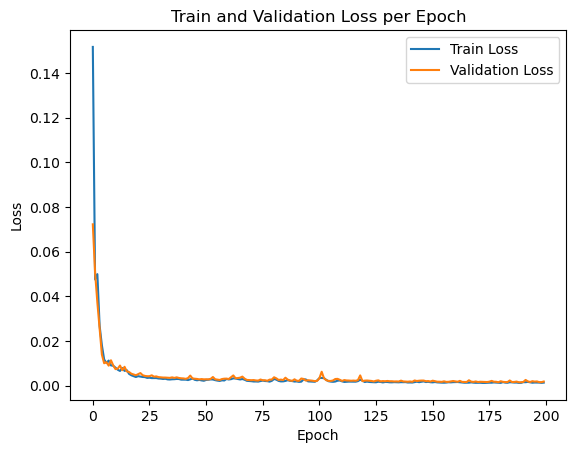

In [10]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss per Epoch')
plt.savefig('train_val_loss_plot.png')
plt.show()


In [26]:
# unet.eval()
# test_loss = 0.0

# with torch.no_grad():
#     for rain, norain in test_loader:
#         rain = rain.to(device)
#         norain = norain.to(device)

#         with autocast():
#             output = unet(rain)
#             loss = criterion(output, norain)

#         test_loss += loss.item()

# print(f"Test loss: {test_loss/len(test_loader):.6f}")


Test loss: 0.003194


In [11]:
# Test the model and save derained images
print('--- Testing starts! ---')
start_time_test = time.time()

unet.eval()
test_psnr = 0.0
test_ssim = 0.0
output_path = "G:\My Drive\Deraining\Rain100L\derained"
if not os.path.exists(output_path):
    os.makedirs(output_path)
metrics = []
with torch.no_grad():
    img_count = 1
    for i, (rain, norain) in enumerate(test_loader):
        rain = rain.to(device)
        norain = norain.to(device)

        output = unet(rain)
        output = output.cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)
        norain = norain.cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)

        for j in range(output.shape[0]):
            # Save the derained image
            output_img = Image.fromarray((output[j] * 255).astype(np.uint8))
            output_img.save(os.path.join(output_path, f"derained_{img_count}.png"))

            # Compute PSNR and SSIM
            cur_psnr = psnr(norain[j], output[j], data_range=1)
            cur_ssim = ssim(norain[j], output[j], data_range=1, multichannel=True)

            metrics.append([cur_psnr, cur_ssim])
            img_count += 1

# Save the metrics to a CSV file and compute the average and standard deviation
metrics_df = pd.DataFrame(metrics, columns=["PSNR", "SSIM"])
metrics_df.to_csv("metrics.csv", index=False)

mean_psnr = metrics_df["PSNR"].mean()
mean_ssim = metrics_df["SSIM"].mean()
std_psnr = metrics_df["PSNR"].std()
std_ssim = metrics_df["SSIM"].std()

print(f"Average PSNR: {mean_psnr:.6f} (std: {std_psnr:.6f}), Average SSIM: {mean_ssim:.6f} (std: {std_ssim:.6f})")

--- Testing starts! ---


C:\Users\labuser\AppData\Local\Temp\ipykernel_360\1426726481.py:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cur_ssim = ssim(norain[j], output[j], data_range=1, multichannel=True)


Average PSNR: 29.452295 (std: 2.603450), Average SSIM: 0.892807 (std: 0.069882)
